In [1]:
%matplotlib inline
from IPython.display import SVG, display, Image


Typed directed graphs
=====================


Preliminaries: setting up the Jupyter environment
-------------------------------------------------

A convenient method to experiment with this document consists in starting up a ``Jupyter Lab`` instance: navigate
to the ``docs/py_and_ipynb_examples`` folder of your local copy of the repository in a terminal and execute the command ::

  $ jupyter lab TypedDirectedGraphs-experiments.ipynb

This will open an interactive ``Jupyter`` session of the present notebook.




Assuming that the current working directory of the Python instance is theaforementioned \
``docs/py_and_ipynb_examples`` sub-directory of the ``ReSMT``  package main directory, the package is loaded as follows:



In [2]:
import os
import sys
sys.path.insert(0, os.path.abspath('../../'))
import resmt.datatypes as datatypes
import resmt.experiments as experiments
import resmt.visualizations as visualizations

import numpy
import networkx as nx
import z3

<div class="alert alert-info"><h4>Note</h4><p>If running the Python file from within an IDE such as e.g. PyCharm, it is alternatively possible to change the working directory to the ``docs/py_and_ipynb_examples`` folder manually before running the above code within the IDE, as in ::

    $ os.chdir('/local/path/to/ReSMT/docs/py_and_ipynb_examples')</p></div>



Overview of datatype design principles and first examples
---------------------------------------------------------

The design philosophy of ``ReSMT`` consists in attempting a direct *translation* of the mathematical \
concepts developed in categorical rewriting theories into first order logic formulas amenable to \
be further analysed via an SMT solver or theorem prover. As such, every datatype in this library \
serves the dual purpose of faithfully encoding the category-theoretical datatypes as well as the \
encoding of the data into logical formulas. We exemplify this concept with two of the base datatypes. \
i.e. the classes ``Z3TypedSet`` of typed sets and ``Z3TypedFunction`` for functions of typed sets. \
Let us first set up some instances of these classes, highlighting in particular the special cases of \
empty sets and functions thereof. Note that all constructions require a ``Z3`` solver instance, \
which may be set up as follows:



In [3]:
S = z3.Solver()

Typed sets
----------




In [ ]:
emptySet = datatypes.Z3TypedSet(S, 'emptySet', {})

It is important to note that an empty set for technical reasons still must contain a \
*nil-element*, and that (since all sets for this module must be typed) this nil-element \
is assigned a default type ``'_DEFAULT'``:



In [ ]:
print(emptySet.els)             # returns {}, as the set has no elements
print(emptySet.sorts)           # the only sort is '_DEFAULT'
print(emptySet.nilEls)          # the sort '_DEFAULT' is inhabited by only the nil-element of that sort

We next consider an example of a non-empty typed set:



In [ ]:
setA = datatypes.Z3TypedSet(S, 'setA', {'a':'elSort1', 'b':'elSort1', 'c':'elSort2'})

The following examples illustrate our ``datatypes`` API, demonstrating how the dictionary of \
elements with names as keys and sorts as values, the set of  element sorts, the dictionary of \
nil-elements accessed by sorts as keys, and finally the direct access to elements by their names \
are accessible:



In [ ]:
print(setA.els)             # element name:sort dictionary
print(setA.sorts)           # set of sorts in the set
print(setA.getEl('a'))      # retrieves the Z3 constant assigned to the element

A more subtle point of our implementation concerns the concrete encoding of the finite typed sets \
in terms of the ``Z3`` API. Technically, a finite set is encoded as a ``z3.EnumSort``, which entails \
in practice that for each subset of elements of a given sort, one such enumeration sort is \
instantiated, and for each of the elements plus for the nil-element of the sort, a special \
``Z3`` constant is instantiated as part of the ``z3.EnumSort`` instantiation. In effect, the \
``Z3`` enumeration sort permits to instantiate a ``Z3`` constant (of that sort) that faithfully \
encodes the concept of "an element in the finite subset of the given sort", which is a key concept \
in many of the algorithms of ``ReSMT``. For this reason, this important notion of "one enumeration \
sort per element sort" is made accessible via the ``.subsets[srt]`` field of a ``Z3TypedSet`` instance, \
which stores the aforementioned instantiation of the enumeration sort, while the field \
``.subsetEls[srt]`` stores all of the ``Z3`` constants representing the elements of the finite \
subset of sort ``srt``:



In [ ]:
print(setA.subsets)                     # renders a dictionary with all enumeration sorts (by sort name)
print(setA.subsetEls['elSort1'])        # the Z3 constants [nil|elSort1, a, b] "inhabiting" the first sort
print(setA.subsetEls['elSort2'])        # the Z3 constants [nil|elSort2, c] "inhabiting" the second sort

Functions of typed sets
-----------------------

Given two typed sets ``setA`` and ``setB``, a function between these two typed sets is effectively \
a collection of functions between the subsets induced by sorts  of elements. For technical reasons, \
we currently only support **one codomain sort per domain sort**, i.e. we do not allow **sort-signatures** \
where elements of a given domain sort are mapped by the functions to codomain elements of more \
than one sort. Another fine-detail concerns the **totality** of functions: if a non-total function \
is specified, this is typically used to set up a "template" of a typed function, such as in cases \
where a given algorithm should construct a function via the ``Z3`` methods. The nature of the \
function being initialized as non-total is also documented in the log file for the module. Let us \
first consider an example of a total typed function:



In [ ]:
setD = datatypes.Z3TypedSet(S, 'domSet', {'a1': 'sortX', 'a2': 'sortX', 'a3': 'sortY'})
setC = datatypes.Z3TypedSet(S, 'codomSet', {'b1': 'sortX', 'b2': 'sortX', 'b3': 'sortY', 'b4': 'sortZ'})
f = datatypes.Z3TypedFunction(S,'f', setD, setC, {'a1': 'b2', 'a2': 'b1', 'a3': 'b4'}, isInjective = True)

The sort maps of ``f`` are accessible via the field ``f.srtMaps``:



In [ ]:
print(f.srtMaps)

Subfunctions are stored in the field ``.subFunctions`` as a dictionary with keys the sort names \
and values the ``Z3`` function instances for the subfunctions:



In [ ]:
print(f.subFunctions)

Most importantly, the instantiation of a ``Z3TypedFunction`` has the side-effect of uploading \
logical assertions to the chosen ``Z3`` solver instance that encode the properties of the typed \
function, such as in particular the consistent sort-wise mapping of nil-elements, the injectivity \
or surjectivity (if specified) and any concrete mapping that was specified in the ``fData`` part \
of the input data. This information may also be accessed directly via the ``.asts`` field:



In [ ]:
for ast in f.asts:
    print(ast)

As a special case, consider below as another example a function of empty sets:



In [ ]:
emptySet = datatypes.Z3TypedSet(S, 'emptySet', {})
g = datatypes.Z3TypedFunction(S,'g', emptySet, emptySet, {})

One may verify that indeed the carrier sets are just the nil-elements of ``'_DEFAULT'`` sort, and \
that the assertions made are purely the nil-element mappings:



In [ ]:
print(g.domSet.els)
print(g.domSet.nilEls)
print(g.codomSet.els)
print(g.codomSet.nilEls)
for ast in g.asts:
    print(ast)

Predicates over typed sets
--------------------------

For several of our algorithms, we need to define predicates over typed sets. The first kind of \
predicate is a simple Boolean predicate, which internally is implemented as a collection of \
Boolean predicates (one for each subset induced by element sorts). Note that this type of object \
inherits the ``Z3`` solver instance from its domain set upon instantiation! Note also that \
strictly speaking the instantiation given below does not fully specify a Boolean predicate beyond \
some elementary consistency assertions (asserting that the nil-elements are always carrying the \
predicate ``True``), since in the use cases present in ``ReSMT`` the predicates will be further \
refinedd as part of certain ``Z3``-based search algorithms. As a somewhat counter-intuitive \
consequence, an instance of such a predicate is not "functional" per se, in that only upon \
rendering a model for the assertions that encode the predicate can one evaluate it in the form of \
this model on concrete elements.



In [ ]:
setD = datatypes.Z3TypedSet(S, 'domSet', {'a1': 'sortX', 'a2': 'sortX', 'a3': 'sortY'})
predD = datatypes.Z3TypedSetPredicate('predD', setD)

for ast in predD.asts:
    print(ast)

The second type of predicate implemented in ``ReSMT`` is that of a **typed span predicates**, or, \
more precisely, templates thereof. The idea of this construction is that these predicates encode \
**partial overlaps** of typed sets, and that the ternary predicate functions encode which elements \
are in "partial overlap" via the span.



In [ ]:
setA = datatypes.Z3TypedSet(S, 'setA', {'a1':'sortX', 'a2':'sortX', 'a3': 'sortY'})
setB = datatypes.Z3TypedSet(S, 'setB', {'b1':'sortX', 'b2':'sortX', 'b3': 'sortY', 'b4':'sortZ'})

Note that one must ensure that both sets have the exact same sort content, which may be \
achieved via "patching" suitable nil-elements if necessary as follows:



In [ ]:
setA.patchNilElements(setB)
setB.patchNilElements(setA)

spanPredAB = datatypes.Z3TypedSetSpanPredicateTemplate('predAB', setA, setB, isMonic=True)

Postponing an in-detail discussion of this concept to a later point (i.e. when discussing the \
TDG overlap finding routines), suffice it here to illustrate the assertions instantiated for a \
typed set span predicate template, which encode consistent nil-element mapping as well as \
"bi-injectivity" in case of monic span predicates:



In [ ]:
for ast in spanPredAB.asts:
    print(ast)

Finally, we will need a form of template for automorphisms of typed sets, which again will serve \
in later algorithms to search for such automorphisms via ``Z3`` (rather than specifying such \
automorphisms manually).



In [ ]:
setD = datatypes.Z3TypedSet(S, 'domSet', {'a1': 'sortX', 'a2': 'sortX', 'a3': 'sortY'})  # the domain set
autD = datatypes.Z3TypedSetAutomorphismTemplate('autD', setD)        # the automorphism template

print('\n Assertions encoding the automorphism property:\n')
for ast in autD.asts:
    print(ast)

Introducing typed directed graphs
---------------------------------

A typed directed graph (TDG) is the following collection of data:

1. A set of vertices $V$ and a set of edges $E$.
2. Source and target functions $s,t: E\rightarrow V$.
3. Typing functions $\tau_V:V\rightarrow T_V$ and $\tau_E:E\rightarrow T_E$.

**Note:** For technical reasons, at the moment we have not yet implemented the most general possible \
form of typing as described above, but only a variant where a given edge type is equipped with a **fixed** \
type-signature, i.e. all edges of a given type have a particular source- and target-type. This feature may be \
changed in a future version of the code. Concretely, this entails the following statement:

\begin{align}\forall e\in E: \tau_E(e) &= t_e\,,\; \tau_V(s(e))= t_{s(e)}\,. \; \tau_V(t(e)) = t_{t(e)}\\
  \Rightarrow \quad \forall e'\in E:\tau_E(e')&=t_e: \tau_V(s(e'))=t_{s(e)} \land \tau_V(t(e'))=t_{t(e)}\,.\end{align}


Let us first experiment with the API provided in the ``datatypes.py`` in order to set up a \
typed directed graph, en passent also illustrating the data format for entering TDGs. \
We first demonstrate how to set up an empty TDG.



In [4]:
Gempty = datatypes.Z3TypedDirectedGraph(S, 'gEmpty', {}, {}, {})

As expected, this graph only contains nil-elements of the ``'_DEFAULT'`` sort for the vertex \
and for the edge carrier sets, and just an assertion that the nil-edge has the nil-vertex as \
both its source and target:



In [ ]:
print(Gempty.vertices.els)
print(Gempty.vertices.nilEls)
print(Gempty.edges.els)
print(Gempty.edges.nilEls)

print(Gempty.src.asts)
print(Gempty.trgt.asts)

Next, let us instantiate a non-empty typed directed graph:



In [5]:
vDictA = {'v1':'sortX', 'v2': 'sortX', 'v3': 'sortY'}                       # the vertex carrier set
eDictA = {'e1':'sortW', 'e2': 'sortT'}                                      # the edge carrier set
stDictA = {'e1':('v1','v2'), 'e2':('v3','v1')}                              # source/target incidence data
graphA = datatypes.Z3TypedDirectedGraph(S, 'gA', vDictA, eDictA, stDictA)

Here is an overview of how this data is encoded:



In [ ]:
print('\n Vertex carrier set:\n')
print(graphA.vertices.els)
print(graphA.vertices.nilEls)
print('\n Edge carrier set:\n')
print(graphA.edges.els)
print(graphA.edges.nilEls)
print('\n Source function assertions:\n')
for ast in graphA.src.asts:
    print(ast)
print('\n Target function assertions:\n')
for ast in graphA.trgt.asts:
    print(ast)

Methods for visualization of TDGs are provided in the ``visualizations`` sub-module of ReSMT. The \
following code will both render a visualization of the TDG ``graphA`` from the above example and \
also save the plot to an SVG gile:



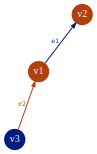

In [6]:
visA = visualizations.nxTypedDirectedGraph(graphA,
                                    drawGraph=True,
                                    writeGraph=True,
                                    fileName='graphA.svg', gLayout='neato')

visA.display

For certain operations such as determining whether two typed directed graphs can be isomorphic, \
it is important to verify first that the two TDGs are **sort compatible**, in the sense that their \
underlying vertex and edge carrier sets have the same sorts, and that the source/target maps \
have the same sort-signatures in both graphs. Compared to a full isomorphism check, this operation \
merely checks for sort compatibility, which is in particular only a look-up operation on the Python-\
parts of the data, and thus very efficient as compared to a more in-depth comparison opeeration.
Let us define another TDG, and then compare a number of TDGs to each other:




graphA is sort-compatible with Gempty:	 False

graphA is sort-compatible with graphA:	 True

graphB is sort-compatible with graphA:	 False


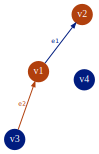

In [7]:
vDictB = {'v1':'sortX', 'v2': 'sortX', 'v3': 'sortZ', 'v4': 'sortZ'}        # the vertex carrier set
eDictB = {'e1':'sortW', 'e2': 'sortT'}                                      # the edge carrier set
stDictB = {'e1':('v1','v2'), 'e2':('v3','v1')}                              # source/target incidence data
graphB = datatypes.Z3TypedDirectedGraph(S, 'gB', vDictB, eDictB, stDictB)

print('\ngraphA is sort-compatible with Gempty:\t %s' % graphA.isSortCompatibleWith(Gempty))    # returns False, as the sorts do not match of course
print('\ngraphA is sort-compatible with graphA:\t %s' % graphA.isSortCompatibleWith(graphA))    # returns True
print('\ngraphB is sort-compatible with graphA:\t %s' %graphB.isSortCompatibleWith(graphA))     # returns False

visB = visualizations.nxTypedDirectedGraph(graphB,
                                    drawGraph=True,
                                    writeGraph=True,
                                    fileName='graphB.svg', gLayout='neato')
visB.display

(Templates of) boolean predicates over TDGs
-------------------------------------------

Just as for typed sets, we will need to construct boolean predicates over TDGs, where again only \
certain sets of assertions made for consistency are instantiated (such as the consistent mapping of \
nil-elements etc.), while the main structure of the predicate is to be instantiated in search algorithms \
via ``Z3``. Suffice it here to provide a concrete coding example for such a predicate, illustrating \
in particular the set of assertions rendered:



In [ ]:
vDictA = {'v1': 'sortX', 'v2': 'sortX', 'v3': 'sortY'}
eDictA = {'e1': 'sortW', 'e2': 'sortT'}
stDictA = {'e1': ('v1', 'v2'), 'e2': ('v3', 'v1')}
graphA = datatypes.Z3TypedDirectedGraph(S, 'gA', vDictA, eDictA, stDictA)
predGraphA = datatypes.Z3TDGpredicate('predGraphA', graphA)

for ast in predGraphA.asts:
    print(ast)

(Templates of) boolean span predicates over TDGs
------------------------------------------------

In our main algorithms for searching for overlaps between typed directed graphs, we need to be able \
to set up templates for (monic) boolean span predicates over TDGs. Each such predicate consists of \
a collection of bi-variate functions (one per sort of vertices and of edges), which encodes the \
membership of the elements in its first and second arguments as a ``True`` or ``False`` boolean \
value. We present here a concrete example of such a TDG boolean span predicate instance, and also \
highight the assertions rendered at its instantiation:



In [ ]:
S = z3.Solver()

# Definition of first TDG:
vDictA = {'v1':'sortX', 'v2': 'sortX', 'v3': 'sortY', 'v4': 'sortZ'}
eDictA = {'e1':'sortW', 'e2': 'sortT'}
stDictA = {'e1':('v1','v2'), 'e2':('v3','v1')}
graphA = datatypes.Z3TypedDirectedGraph(S, 'gA', vDictA, eDictA, stDictA)

# Definition of second TDG:
vDictB = {'v1': 'sortX', 'v2': 'sortX', 'v3': 'sortX', 'v4': 'sortY'}
eDictB = {'e1': 'sortW', 'e2': 'sortT', 'e3': 'sortT'}
stDictB = {'e1': ('v2', 'v1'), 'e2': ('v4', 'v3'), 'e3': ('v4', 'v1')}
graphB = datatypes.Z3TypedDirectedGraph(S, 'gB', vDictB, eDictB, stDictB)

# Patching of nil-elements in order to render the sorts of the TDGs compatible:
graphA.patchNilElements(graphB)
graphB.patchNilElements(graphA)

# Instantiate the boolean span predicate:
spanPredAB = datatypes.Z3TDGspanPredicateTemplate('spanPredAB', graphA, graphB)

The structure of the boolean span predicate (template) is best understood via the set of \
assertions that encode it:



In [ ]:
for ast in spanPredAB.asts:
    print(ast)

Finding forbidden TDG relations
-------------------------------

A core computational tool for the static analysis of rewriting systems over typed directed graphs \
that are restricted to not contain certain "forbidden patterns" is the notion of **"forbidden relations"**. \
We introduced this novel approach in our *GCM 2020* workshop contribution \
*"Efficient Computation of Graph Overlaps for Rule Composition: Theory and Z3 Prototyping"* \
(which contains also the full theoretical derivation of the relevant concepts). \
Intuitively, given a "forbidden pattern" ``N`` (which is itself some typed directed multigraph), \
the computation of the set of all "forbidden relations" may be performed as follows:

1. Determine those monic spans of subgraphs $(A \hookleftarrow M \hookrightarrow B)$ such that

      a) none of the three subgraphs of ``N`` contans ``N`` as a subgraph themselves, and
      b) the **pushout** ("the glueing of ``A`` with ``B`` along overlap ``M``") is isomorphic to ``N``.

2. Only retain one representative per isomorphism class of "forbidden relations", where the relevant \
   isomorphisms are those induced by automorphisms of ``N``.

**Reference:** N. Behr, M. Ghaffari Saadat and R. Heckel, "Efficient Computation of Graph Overlaps for Rule \
Composition: Theory and Z3 Prototyping" (contained in the \
`pre-proceedings <https://sites.google.com/view/gcm2020/preproc>`_ of the  \
`GCM 2020: Eleventh International Workshop \
on Graph Computation Models <https://sites.google.com/view/gcm2020/>`_)



Let us first set up a "forbidden pattern", e.g. as a first simple example a "star graph" with a \
number ``nLegs`` of outwards-pointing edges (with all vertices and edges of the same type):



**Case** ``nLegs = 2``:



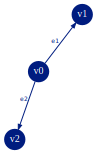

In [11]:
nLegs = 2

# Definition of a "forbidden" TDG pattern:

S = z3.Solver()

vDictN = {'v'+str(i): 'sortX' for i in range(nLegs + 1)}
eDictN = {'e'+str(i): 'sortX' for i in range(1, nLegs + 1)}
stDictN = {'e'+str(i):('v0','v'+str(i)) for i in range(1, nLegs + 1)}
graphN = datatypes.Z3TypedDirectedGraph(S, 'gN', vDictN, eDictN, stDictN)

visN = visualizations.nxTypedDirectedGraph(graphN,
                                    drawGraph=True,
                                    writeGraph=True,
                                    fileName='images/graphN-nLegs=%s.svg' % nLegs,
                                    gLayout='neato')
visN.display

Running the forbidden relation search itself:



In [13]:
FRs, execTimes, solverStats = datatypes.genForbiddenTDGrelations(graphN)

The routine detected the following forbidden relations:



In [14]:
for fr in FRs:
    print(fr)

{'v0|V': '=', 'v1|V': '<', 'v2|V': '>', 'e1|E': '<', 'e2|E': '>'}
{'v0|V': '=', 'v1|V': '<', 'v2|V': '=', 'e1|E': '<', 'e2|E': '>'}
{'v0|V': '=', 'v1|V': '=', 'v2|V': '=', 'e1|E': '<', 'e2|E': '>'}
{'v0|V': '=', 'v1|V': '=', 'v2|V': '>', 'e1|E': '<', 'e2|E': '>'}


The execution times of the ``Z3`` solver for each run (until the last ``unsat`` run) are plotted below:



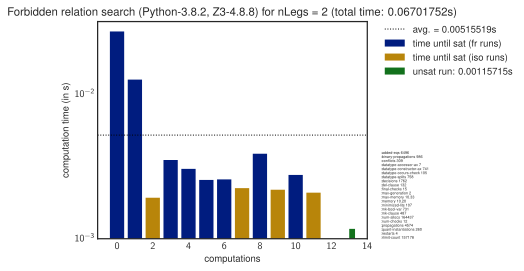

In [15]:
totalTime = numpy.round(sum([x[0] for x in execTimes]), 8)
titleStr = 'Forbidden relation search (Python-3.8.2, Z3-4.8.8) ' \
           + 'for nLegs = %s (total time: %ss)' % (nLegs, totalTime)
fN = 'images/fr-nLegs=%s-Z3-timings' % nLegs
statStr = str(solverStats)[1:-1]
experiments.genFrExecTimePlot(execTimes, statStr, titleStr, fN)

![](images/graphN-nLegs=2.svg)


![](images/fr-nLegs=2-Z3-timings.svg)




**Case** ``nLegs = 3``:



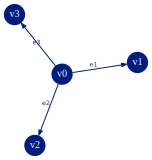

In [16]:
nLegs = 3

# Definition of a "forbidden" TDG pattern:

S = z3.Solver()

vDictN = {'v'+str(i): 'sortX' for i in range(nLegs + 1)}
eDictN = {'e'+str(i): 'sortX' for i in range(1, nLegs + 1)}
stDictN = {'e'+str(i):('v0','v'+str(i)) for i in range(1, nLegs + 1)}
graphN = datatypes.Z3TypedDirectedGraph(S, 'gN', vDictN, eDictN, stDictN)

visN = visualizations.nxTypedDirectedGraph(graphN,
                                    drawGraph=True,
                                    writeGraph=True,
                                    fileName='images/graphN-nLegs=%s.svg' % nLegs)
visN.display

Running the forbidden relation search itself:



In [ ]:
FRs, execTimes, solverStats = datatypes.genForbiddenTDGrelations(graphN)

The routine detected the following forbidden relations:



In [ ]:
for fr in FRs:
    print(fr)

The execution times of the ``Z3`` solver for each run (until the last ``unsat`` run) are plotted below:



In [ ]:
totalTime = numpy.round(sum([x[0] for x in execTimes]), 8)
titleStr = 'Forbidden relation search (Python-3.8.2, Z3-4.8.8) ' \
           + 'for nLegs = %s (total time: %ss)' % (nLegs, totalTime)
fN = 'images/fr-nLegs=%s-Z3-timings' % nLegs
statStr = str(solverStats)[1:-1]
experiments.genFrExecTimePlot(execTimes, statStr, titleStr, fN)

![](images/graphN-nLegs=3.svg)


![](images/fr-nLegs=3-Z3-timings.svg)




**Case** ``nLegs = 4``:



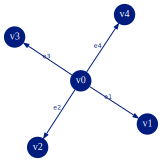

In [17]:
nLegs = 4

# Definition of a "forbidden" TDG pattern:

S = z3.Solver()

vDictN = {'v'+str(i): 'sortX' for i in range(nLegs + 1)}
eDictN = {'e'+str(i): 'sortX' for i in range(1, nLegs + 1)}
stDictN = {'e'+str(i):('v0','v'+str(i)) for i in range(1, nLegs + 1)}
graphN = datatypes.Z3TypedDirectedGraph(S, 'gN', vDictN, eDictN, stDictN)

visN = visualizations.nxTypedDirectedGraph(graphN,
                                    drawGraph=True,
                                    writeGraph=True,
                                    fileName='images/graphN-nLegs=%s.svg' % nLegs)

visN.display

Running the forbidden relation search itself:



In [ ]:
FRs, execTimes, solverStats = datatypes.genForbiddenTDGrelations(graphN)

The routine detected the following forbidden relations:



In [ ]:
for fr in FRs:
    print(fr)

The execution times of the ``Z3`` solver for each run (until the last ``unsat`` run) are plotted below:



In [ ]:
totalTime = numpy.round(sum([x[0] for x in execTimes]), 8)
titleStr = 'Forbidden relation search (Python-3.8.2, Z3-4.8.8) ' \
           + 'for nLegs = %s (total time: %ss)' % (nLegs, totalTime)
fN = 'images/fr-nLegs=%s-Z3-timings' % nLegs
statStr = str(solverStats)[1:-1]
experiments.genFrExecTimePlot(execTimes, statStr, titleStr, fN)

![](images/graphN-nLegs=4.svg)


![](images/fr-nLegs=4-Z3-timings.svg)




**(To be continued!)**



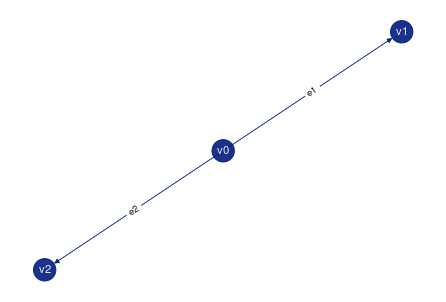

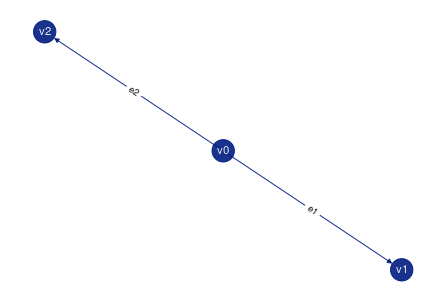

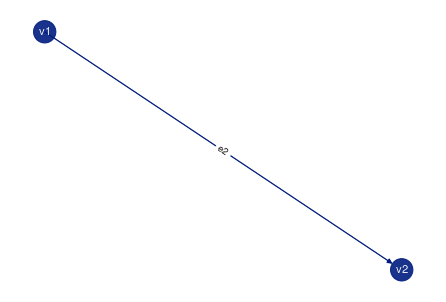

In [3]:
# Definition of the three "forbidden" TDG patterns:

S = z3.Solver()

vDictN1 = {'v'+str(i): 'sortX' for i in range(3)}
eDictN1 = {'e'+str(i): 'sortX' for i in range(1, 3)}
stDictN1 = {'e'+str(i):('v0','v'+str(i)) for i in range(1, 3)}
graphN1 = datatypes.Z3TypedDirectedGraph(S, 'gN1', vDictN1, eDictN1, stDictN1)

visualizations.nxTypedDirectedGraph(graphN1,
                                    drawGraph=True,
                                    writeGraph=True,
                                    fileName='images/graphN1.svg',
                                    gLayout='fr')

vDictN2 = {'v'+str(i): 'sortX' for i in range(3)}
eDictN2 = {'e'+str(i): 'sortX' for i in range(1, 3)}
stDictN2 = {'e'+str(i):('v'+str(i),'v0') for i in range(1, 3)}
graphN2 = datatypes.Z3TypedDirectedGraph(S, 'gN2', vDictN2, eDictN2, stDictN2)

visualizations.nxTypedDirectedGraph(graphN1,
                                    drawGraph=True,
                                    writeGraph=True,
                                    fileName='images/graphN2.svg',
                                    gLayout='fr')

vDictN3 = {'v1': 'sortX', 'v2': 'sortX'}
eDictN3 = {'e1': 'sortX', 'e2': 'sortX'}
stDictN3 = {'e1': ('v1', 'v2'), 'e2': ('v1', 'v2')}
graphN3 = datatypes.Z3TypedDirectedGraph(S, 'gN3', vDictN3, eDictN3, stDictN3)

visualizations.nxTypedDirectedGraph(graphN3,
                                    drawGraph=True,
                                    writeGraph=True,
                                    fileName='images/graphN3.svg',
                                    gLayout='fr')



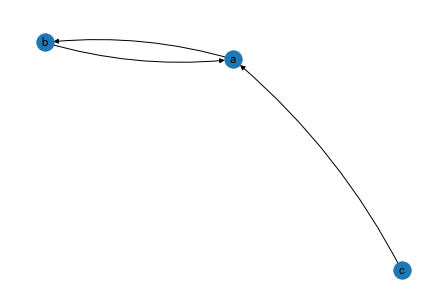

In [7]:
g1 = nx.MultiDiGraph(directed=True)

node1 = 'a'
node2 = 'b'
node3 = 'c'



g1.add_edge(node1,node2,key=1)
g1.add_edge(node2,node1,key=2)
g1.add_edge(node3,node1,key=2)



nx.draw(g1, with_labels=True, arrows = True, connectionstyle='arc3, rad = 0.1')


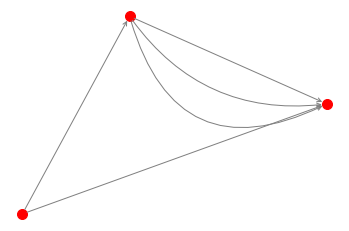

In [14]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import style

G=nx.MultiGraph ([(1,2),(1,2),(1,1),(1,2),(3,1),(3,2)])
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, node_color = 'r', node_size = 100, alpha = 1)
ax = plt.gca()
for e in G.edges:
    ax.annotate("",
                xy=pos[e[0]], xycoords='data',
                xytext=pos[e[1]], textcoords='data',
                arrowprops=dict(arrowstyle="->", color="0.5",
                                shrinkA=5, shrinkB=5,
                                patchA=None, patchB=None,
                                connectionstyle="arc3,rad=rrr".replace('rrr',str(0.3*e[2])
                                ),
                                ),
                )
plt.axis('off')
plt.show()


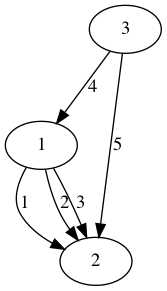

In [18]:
import networkx as nx
import matplotlib.pyplot as plt
from IPython.display import Image

G=nx.MultiDiGraph ()
G.add_edge(1,2,weight=1)
G.add_edge(1,2,weight=2)
G.add_edge(1,2,weight=3)
G.add_edge(3,1,weight=4)
G.add_edge(3,2,weight=5)
for edge in G.edges(data=True): edge[2]['label'] = edge[2]['weight']
node_label = nx.get_node_attributes(G,'id')
pos = nx.spring_layout(G)
node_label = nx.get_node_attributes(G,'id')
pos = nx.spring_layout(G)
p=nx.drawing.nx_pydot.to_pydot(G)
p.write_png('multi.png')
Image(filename='multi.png')


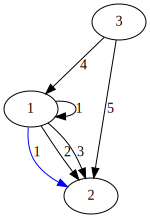

In [30]:
import networkx as nx
import matplotlib.pyplot as plt

G=nx.MultiDiGraph()
G.add_edge(1,1,weight=1)
G.add_edge(1,2,weight=1, color='blue')
G.add_edge(1,2,weight=2)
G.add_edge(1,2,weight=3)
G.add_edge(3,1,weight=4)
G.add_edge(3,2,weight=5)
for edge in G.edges(data=True): edge[2]['label'] = edge[2]['weight']
node_label = nx.get_node_attributes(G,'id')
pos = nx.spring_layout(G)
node_label = nx.get_node_attributes(G,'id')
pos = nx.spring_layout(G)
p=nx.drawing.nx_pydot.to_pydot(G)

SVG(p.create(prog='dot', format = 'svg'))

In [38]:
p=nx.drawing.nx_pydot.to_pydot(visA.graph)

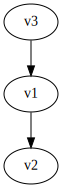

In [40]:
SVG(p.create(prog='dot', format = 'svg'))

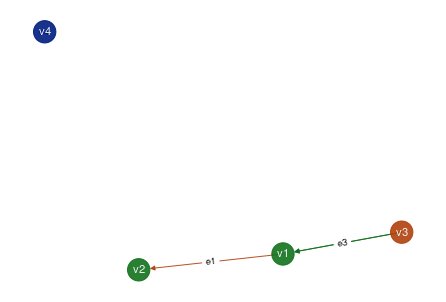

In [68]:
S = z3.Solver()

# Definition of first TDG:
vDictA = {'v1':'sortX', 'v2': 'sortX', 'v3': 'sortY', 'v4': 'sortZ'}
eDictA = {'e1':'sortW', 'e2': 'sortT', 'e3': 'sortT', 'e4': 'sortL'}
stDictA = {'e1':('v1','v2'), 'e2':('v3','v1'), 'e3':('v3','v1'), 'e4':('v4','v4')}
graphA = datatypes.Z3TypedDirectedGraph(S, 'gA', vDictA, eDictA, stDictA)

visA = visualizations.nxTypedDirectedGraph(graphA,
                                    drawGraph=True,
                                    writeGraph=True,
                                    fileName='graphA.svg',
                                    gLayout='fr')

In [189]:
visA.graph.edges()

OutMultiEdgeDataView([('v1', 'v2'), ('v3', 'v1'), ('v3', 'v1'), ('v4', 'v4')])

In [191]:
help(pydot.Edge)

Help on class Edge in module pydot:

class Edge(Common)
 |  Edge(src='', dst='', obj_dict=None, **attrs)
 |  
 |  A graph edge.
 |  
 |  This class represents a graph's edge with all its attributes.
 |  
 |  edge(src, dst, attribute=value, ...)
 |  
 |  src: source node
 |  dst: destination node
 |  
 |  `src` and `dst` can be specified as a `Node` object,
 |  or as the node's name string.
 |  
 |  All the attributes defined in the Graphviz dot language should
 |  be supported.
 |  
 |      Attributes can be set through the dynamically generated methods:
 |  
 |   set_[attribute name], i.e. set_label, set_fontname
 |  
 |  or directly by using the instance's special dictionary:
 |  
 |   Edge.obj_dict['attributes'][attribute name], i.e.
 |  
 |      edge_instance.obj_dict['attributes']['label']
 |      edge_instance.obj_dict['attributes']['fontname']
 |  
 |  Method resolution order:
 |      Edge
 |      Common
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __eq__(self

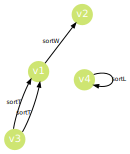

In [187]:
p=nx.drawing.nx_pydot.to_pydot(visA.graph)


for n in p.get_nodes():
    nSort = n.get_attributes()['sort']
    n.set_shape('circle')
    n.set_style('filled')
    n.set_fontname('Lato')
    n.set_fontsize('10pt')
    n.set_margin('0.025')
    n.set_height('0')
    n.set_width('0')
    n.set_penwidth('0')
    n.set_color('white')
    n.set_fontcolor('white')
    n.set_fillcolor('0.2 0.5 0.9')
    # print('%s\n' % n.get_attributes())
    
for e in p.get_edges():
    e.set_arrowsize('0.5')
    eSrt = e.get('sort')
    e.set_fontsize('6pt')
    e.set_fontname('Lato')
    e.set_label(eSrt)

SVG(p.create(prog='neato', format = 'svg'))

{'key': '0',
 'sort': 'sortW',
 'arrowsize': '0.5',
 'fontsize': '6pt',
 'fontname': 'Lato',
 'label': 'sortW'}

In [129]:
p.get_edges()[0].get_attributes()

{'key': '0', 'sort': 'sortW'}

In [124]:
import seaborn as sns

colorPalette = sns.color_palette("dark", 10)

In [126]:
'%s %s %s' % colorPalette[0]

'0.0 0.10980392156862745 0.4980392156862745'

In [107]:
help(p)

Help on Dot in module pydot object:

class Dot(Graph)
 |  Dot(*argsl, **argsd)
 |  
 |  A container for handling a dot language file.
 |  
 |  This class implements methods to write and process
 |  a dot language file. It is a derived class of
 |  the base class 'Graph'.
 |  
 |  Method resolution order:
 |      Dot
 |      Graph
 |      Common
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __getstate__(self)
 |  
 |  __init__(self, *argsl, **argsd)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  __setstate__(self, state)
 |  
 |  create(self, prog=None, format='ps', encoding=None)
 |      Creates and returns a binary image for the graph.
 |      
 |      create will write the graph to a temporary dot file in the
 |      encoding specified by `encoding` and process it with the
 |      program given by 'prog' (which defaults to 'twopi'), reading
 |      the binary image output and return it as:
 |      
 |      - `str` of bytes in Python 

In [102]:
p_layout = {p.nodes[n]['node_label']: p for n, p in p.items()}

AttributeError: 'Dot' object has no attribute 'items'

In [74]:
for n in p.get_nodes():
    print(n)
    
for e in p.get_edges():
    print(e)

v1 [sort=sortX];
v2 [sort=sortX];
v3 [sort=sortY];
v4 [sort=sortZ];
v1 -> v2  [key=0, sort=sortW];
v3 -> v1  [key=0, sort=sortT];
v3 -> v1  [key=1, sort=sortT];
v4 -> v4  [key=0, sort=sortL];


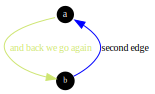

In [192]:
import pydot

p = pydot.Dot(forcelabels='true')


# create one node
nd = pydot.Node("a", 
                shape='circle', 
                fontsize=10,
                width=0,
                height=0,
                margin=0.025,
                style="filled", 
                fillcolor='black', 
                color='white',
                penwidth=4,
                fontcolor='white')

nd2 = pydot.Node("b", 
                shape='circle', 
                fontsize=8,
                width=0,
                height=0,
                margin=0.025,
                style="filled", 
                fillcolor='black', 
                color='white',
                penwidth=0,
                fontcolor='white')


p.add_node(nd)
p.add_node(nd2)

p.add_edge(pydot.Edge("b", "a", 
                      label="second edge", 
                      labelfontcolor="#009933", 
                      fontsize="10.0", color="blue"))
p.add_edge(pydot.Edge("a", "b", 
                      label="and back we go again", 
                      fontcolor="0.2 0.5 0.9", 
                      fontsize="10.0", color="0.2 0.5 0.9"))


# write the SVG image to a file:
p.write("test.svg", format='svg')

# the string representaton of the SVG image:
#print(p.to_string())

# display the SVG image in the Jupyter notebook:
svgImg = SVG(p.create(prog='dot', format = 'svg'))
svgImg

In [202]:
p.write("test.svg", format='svg')

True

In [203]:
testStr='test.SVG'
testStr[-3:].lower()
testStr[:-3]

'test.'

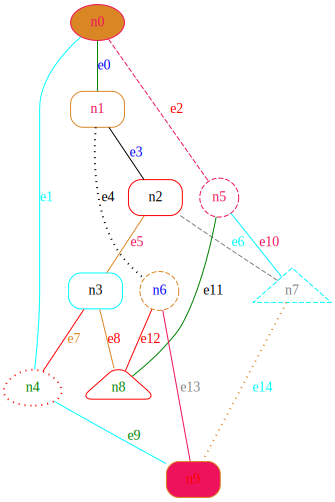

In [67]:
# SOURCE: https://github.com/pydot/pydot/issues/169

import random
import networkx as nx
G = nx.petersen_graph()
pdot = nx.drawing.nx_pydot.to_pydot(G)

shapes = ['box', 'polygon', 'ellipse', 'oval', 'circle', 'egg', 'triangle', 'exagon', 'star', ]
colors = ['blue', 'black', 'red', '#db8625', 'green', 'gray', 'cyan', '#ed125b']
styles = ['filled', 'rounded', 'rounded, filled', 'dashed', 'dotted, bold']

for i, node in enumerate(pdot.get_nodes()):
    node.set_label("n%d" % i)
    node.set_shape(shapes[random.randrange(len(shapes))])
    node.set_fontcolor(colors[random.randrange(len(colors))])
    node.set_fillcolor(colors[random.randrange(len(colors))])
    node.set_style(styles[random.randrange(len(styles))])
    node.set_color(colors[random.randrange(len(colors))])

for i, edge in enumerate(pdot.get_edges()):
    edge.set_label("e%d" % i)
    edge.set_fontcolor(colors[random.randrange(len(colors))])
    edge.set_style(styles[random.randrange(len(styles))])
    edge.set_color(colors[random.randrange(len(colors))])

png_path = "test.svg"
pdot.write_svg(png_path)
SVG(pdot.create(prog='dot', format = 'svg'))

In [163]:
import pygraphviz as pgv
# strict (no parallel edges)
# digraph
# with attribute rankdir set to 'LR'
A=pgv.AGraph(directed=True,strict=True,rankdir='LR')
# add node 1 with color red
A.add_node(1,color='red') 
A.add_node(5,color='blue')
# add some edges
A.add_edge(1,2,color='green')
A.add_edge(2,3)
A.add_edge(1,3)
A.add_edge(3,4)
A.add_edge(3,5)
A.add_edge(3,6)
A.add_edge(4,6)
# adjust a graph parameter
A.graph_attr['epsilon']='0.001'
print(A.string()) # print dot file to standard output
A.layout('dot') # layout with dot
A.draw('foo.ps') # write to file

strict digraph "" {
	graph [epsilon=0.001,
		rankdir=LR
	];
	1	[color=red];
	1 -> 2	[color=green];
	1 -> 3;
	2 -> 3;
	5	[color=blue];
	3 -> 5;
	3 -> 4;
	3 -> 6;
	4 -> 6;
}



In [18]:
import pydot
help(pydot.Dot.write)

Help on function write in module pydot:

write(self, path, prog=None, format='raw', encoding=None)
    Writes a graph to a file.
    
    Given a filename 'path' it will open/create and truncate
    such file and write on it a representation of the graph
    defined by the dot object in the format specified by
    'format' and using the encoding specified by `encoding` for text.
    The format 'raw' is used to dump the string representation
    of the Dot object, without further processing.
    The output can be processed by any of graphviz tools, defined
    in 'prog', which defaults to 'dot'
    Returns True or False according to the success of the write
    operation.
    
    There's also the preferred possibility of using:
    
        write_'format'(path, prog='program')
    
    which are automatically defined for all the supported formats.
    [write_ps(), write_gif(), write_dia(), ...]
    
    The encoding is passed to `open` [1].
    
    [1] https://docs.python.org/3/librar

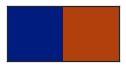

In [23]:
import seaborn as sns
current_palette = sns.color_palette("dark", 2).as_hex()
sns.palplot(current_palette)

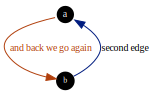

In [25]:
import pydot

p = pydot.Dot(forcelabels='true')


# create one node
nd = pydot.Node("a", 
                shape='circle', 
                fontsize=10,
                width=0,
                height=0,
                margin=0.025,
                style="filled", 
                fillcolor='black', 
                color='white',
                penwidth=4,
                fontcolor='white')

nd2 = pydot.Node("b", 
                shape='circle', 
                fontsize=8,
                width=0,
                height=0,
                margin=0.025,
                style="filled", 
                fillcolor='black', 
                color='white',
                penwidth=0,
                fontcolor='white')


p.add_node(nd)
p.add_node(nd2)

p.add_edge(pydot.Edge("b", "a", 
                      label="second edge", 
                      labelfontcolor="#009933", 
                      fontsize="10.0", color=current_palette[0]))
p.add_edge(pydot.Edge("a", "b", 
                      label="and back we go again", 
                      fontcolor= current_palette[1], 
                      fontsize="10.0", 
                      color= current_palette[1]))


# write the SVG image to a file:
p.write("test.svg", format='svg')

# the string representaton of the SVG image:
#print(p.to_string())

# display the SVG image in the Jupyter notebook:
svgImg = SVG(p.create(prog='dot', format = 'svg'))
svgImg

In [22]:
current_palette.as_hex()

['#001c7f', '#b1400d']